In [1]:
# Step 1: Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Unzip your dataset from Drive into Colab's temporary storage
# This makes file access much faster than reading from Drive directly.
# Make sure the ZIP file name 'archive.zip' is correct.
!unzip /content/drive/MyDrive/archive.zip -d /content/dataset/

Mounted at /content/drive
Archive:  /content/drive/MyDrive/archive.zip
  inflating: /content/dataset/the_wildfire_dataset_2n_version/test/fire/19196558588_267f24b847_o.jpg  
  inflating: /content/dataset/the_wildfire_dataset_2n_version/test/fire/20960888741_8c4be2c1df_o.jpg  
  inflating: /content/dataset/the_wildfire_dataset_2n_version/test/fire/26131736898_9e6a8cd68f_o.jpg  
  inflating: /content/dataset/the_wildfire_dataset_2n_version/test/fire/26549039025_b4cce14ec7_o.jpg  
  inflating: /content/dataset/the_wildfire_dataset_2n_version/test/fire/27002088114_aa5cc7f353_o.jpg  
  inflating: /content/dataset/the_wildfire_dataset_2n_version/test/fire/27335331950_39b376eddd_o.jpg  
  inflating: /content/dataset/the_wildfire_dataset_2n_version/test/fire/27389369514_cd30397ac2_o.jpg  
  inflating: /content/dataset/the_wildfire_dataset_2n_version/test/fire/27951228213_2dd961ac1f_o.jpg  
  inflating: /content/dataset/the_wildfire_dataset_2n_version/test/fire/27968020506_5f1a59f2a5_o.jpg  
  

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
!ls

dataset  drive	sample_data


In [3]:
# !ls /content/dataset/the_wildfire_dataset_2n_version/train/fire
# The new path for your data in Google Colab
data_dir = '/content/dataset/the_wildfire_dataset_2n_version/train'

# Create the full paths to the 'fire' and 'no_fire' subdirectories
fire_path = os.path.join(data_dir, 'fire')
no_fire_path = os.path.join(data_dir, 'nofire')

In [4]:
# List all the files in the 'fire' directory and count them
fire_images = os.listdir(fire_path)
print(f"Found {len(fire_images)} images in the 'fire' directory.")

# Do the same for the 'no_fire' directory
no_fire_images = os.listdir(no_fire_path)
print(f"Found {len(no_fire_images)} images in the 'no_fire' directory.")


Found 730 images in the 'fire' directory.
Found 1157 images in the 'no_fire' directory.


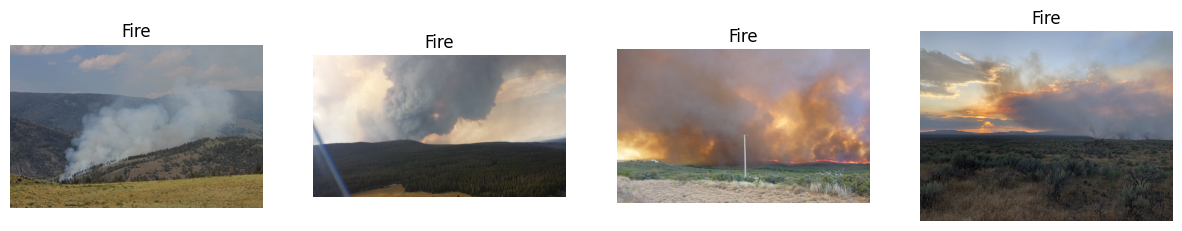

In [5]:
# Get the filenames of the first 4 fire images
sample_fire_images = fire_images[:4]

# Create a figure to display the images
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Loop through the image files and display them
for i, image_name in enumerate(sample_fire_images):
    image_path = os.path.join(fire_path, image_name)
    img = Image.open(image_path)

    axes[i].imshow(img)
    axes[i].set_title('Fire')
    axes[i].axis('off')

plt.show()

Data PreProcessing Pipeline


In [6]:
def preprocess_image(image_path):

    img = Image.open(image_path)
    resized_img = img.resize((new_width, new_height))
    grayscale_image = resized_img.convert('L')
    image_array = np.asarray(grayscale_image)
    rescaled_vector = image_array/255.0
    flattened_image = rescaled_vector.flatten()
    return flattened_image

fire_images = os.listdir(fire_path)
no_fire_images = os.listdir(no_fire_path)


# X A 2D array where each row is a single, flattened image.
# y A 1D array containing the corresponding labels (1 for fire, 0 for no-fire).
X = []
y = []

new_width = 128
new_height = 128

for i, image_name in enumerate(fire_images):

    image_path = os.path.join(fire_path, image_name)
    processed_image = preprocess_image(image_path)
    X.append(processed_image)
    y.append(1)


for i, image_name in enumerate(no_fire_images):

    image_path = os.path.join(no_fire_path, image_name)
    processed_image = preprocess_image(image_path)
    X.append(processed_image)
    y.append(0)





/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Base Line : Logistic Regression Soln


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report

lr = LogisticRegression()

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = lr.fit(X_train, y_train)

print(clf.score(X_test, y_test))

predictions = clf.predict(X_test)

cm = confusion_matrix(y_test,predictions)

print(cm)


0.6137566137566137
[[158  67]
 [ 79  74]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [8]:
from torch.utils.data import Dataset
from torchvision import transforms
import os
from PIL import Image


data_dir_train = '/content/dataset/the_wildfire_dataset_2n_version/train'
data_dir_val = '/content/dataset/the_wildfire_dataset_2n_version/val'
data_dir_test = '/content/dataset/the_wildfire_dataset_2n_version/test'


# Define the transformations for your training data
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),      # Resize images to 224x224 pixels
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.ToTensor(),              # Convert image to a PyTorch tensor
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),      # Necessary preprocessing
    transforms.ToTensor(),              # Necessary preprocessing
])


class WildfireDataset(Dataset):

  def __init__(self, root_dir, transform=None):
    self.data = []
    self.labels = []
    self.transform = transform # Store the transform

    # Construct paths dynamically based on the provided root_dir
    fire_path = os.path.join(root_dir, 'fire')
    nofire_path = os.path.join(root_dir, 'nofire')

    # Define a list of valid image extensions
    image_extensions = ('.jpg', '.jpeg', '.png')

    # This new code checks the file extension before adding the file
    for image_filename in os.listdir(fire_path):
      if image_filename.lower().endswith(image_extensions):
        self.data.append(os.path.join(fire_path, image_filename))
        self.labels.append(1)

    # Do the same for the nofire directory
    for image_filename in os.listdir(nofire_path):
      if image_filename.lower().endswith(image_extensions):
        self.data.append(os.path.join(nofire_path, image_filename))
        self.labels.append(0)


  def __len__(self):
    return len(self.data)  # returns the total number of images you have


  def __getitem__(self, index):
    image = Image.open(self.data[index]).convert('RGB')
    label = self.labels[index]

    if self.transform:
      image = self.transform(image)

    return image, label









In [9]:
from torch.utils.data import DataLoader

# 1. Create an instance of YOUR WildfireDataset
train_dataset = WildfireDataset(root_dir=data_dir_train, transform=train_transforms)

valid_dataset = WildfireDataset(root_dir=data_dir_val, transform=val_transforms)

test_dataset = WildfireDataset(root_dir=data_dir_test, transform=val_transforms)


# 2. Create an instance of PyTorch's DataLoader, passing your dataset to it
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)


# 3. Get a single batch of data
images, labels = next(iter(train_loader))

images, labels = next(iter(valid_loader))

images, labels = next(iter(test_loader))

# Check the results
print(f"Shape of one batch of images: {images.shape}")
print(f"Shape of one batch of labels: {labels.shape}")

Shape of one batch of images: torch.Size([32, 3, 224, 224])
Shape of one batch of labels: torch.Size([32])


In [10]:
from torchvision import models
import torch.nn as nn

# For ResNet-18:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for name, param in model.named_parameters():
    param.requires_grad = False


# Adding a layer at end which takes 512 inputs and gives out 2 outputs
model.fc = nn.Linear(in_features=512, out_features=2)

for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

print(model)



# model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
!ls /content/dataset/the_wildfire_dataset_2n_version/

test  train  val


In [12]:
import torch
import torch.optim as optim
import torch.nn as nn # Make sure you have this import

# --- Setup ---
# 1. Define your loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

params_to_update = [param for param in model.parameters() if param.requires_grad]
optimizer = optim.Adam(params_to_update, lr=0.001)


# 2. Set up the GPU (or CPU if no GPU is available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 3. Move your model to the selected device
model.to(device)

# Initialize a variable to track the best validation loss
best_val_loss = float('inf')


  # Loop over the desired number of epochs
for epoch in range(10):

  # --- TRAINING PHASE ---
  model.train() # Set the model to training mode
  running_train_loss = 0.0
  for images, labels in train_loader:

    # 7. Move the batch of data to the device
    images = images.to(device)
    labels = labels.to(device)

    # 8. Zero the gradients
    optimizer.zero_grad()

    # 9. Forward pass: get model predictions
    output = model(images)

    # 10. Calculate the loss
    loss = loss_fn(output, labels)

    # 11. Backward pass: compute the gradients
    loss.backward()

    # 12. Update the weights
    optimizer.step()

    # 13. Track the loss

    running_train_loss += loss.item()

  # --- VALIDATION PHASE ---
  model.eval() # Set the model to evaluation mode
  running_val_loss = 0.0
  correct_predictions = 0
  total_predictions = 0

  with torch.no_grad(): # No need to calculate gradients for validation
    for images, labels in valid_loader:
      # Move data to the device
      images = images.to(device)
      labels = labels.to(device)

      # Forward pass
      output = model(images)

      # Calculate validation loss
      loss = loss_fn(output, labels)
      running_val_loss += loss.item()

      # Calculate accuracy
      _, predicted = torch.max(output.data, 1)
      total_predictions += labels.size(0)
      correct_predictions += (predicted == labels).sum().item()

  # --- EPOCH SUMMARY ---
  avg_train_loss = running_train_loss / len(train_loader)
  avg_val_loss = running_val_loss / len(valid_loader)
  val_accuracy = (correct_predictions / total_predictions) * 100

  print(f"Epoch {epoch+1}/{10}")
  print(f"  Training Loss: {avg_train_loss:.4f}")
  print(f"  Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")

  # --- SAVE THE BEST MODEL ---
  # Check if the current validation loss is the best we've seen so far
  if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss # Update the best validation loss
    # Save the model's state dictionary to a file
    torch.save(model.state_dict(), 'best_wildfire_model.pth')
    print(f"  Model saved! New best validation loss: {best_val_loss:.4f}")

Using device: cuda


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1/10
  Training Loss: 0.3271
  Validation Loss: 0.3230 | Validation Accuracy: 87.81%
  Model saved! New best validation loss: 0.3230
Epoch 2/10
  Training Loss: 0.1331
  Validation Loss: 0.2904 | Validation Accuracy: 88.81%
  Model saved! New best validation loss: 0.2904
Epoch 3/10
  Training Loss: 0.1069
  Validation Loss: 0.3741 | Validation Accuracy: 86.07%


KeyboardInterrupt: 

In [13]:
# 1. Create a new instance of the model architecture
#    It's important to start with a fresh model
model = models.resnet18() # No pre-trained weights needed here
model.fc = nn.Linear(in_features=512, out_features=2)

# 2. Load the saved weights from your best model
#    Make sure the path 'best_wildfire_model.pth' is correct
model.load_state_dict(torch.load('best_wildfire_model.pth'))

# 3. Move the model to the GPU and set it to evaluation mode
model.to(device)
model.eval()

# --- FINAL TEST ---
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

print("Running final evaluation on the test set...")
with torch.no_grad():
    for images, labels in test_loader:
        # Move data to the device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        output = model(images)

        # Calculate loss
        loss = loss_fn(output, labels)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(output.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# --- FINAL RESULTS ---
avg_test_loss = test_loss / len(test_loader)
test_accuracy = (correct_predictions / total_predictions) * 100

print("\n--- FINAL MODEL PERFORMANCE ---")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.2f}%")

Running final evaluation on the test set...


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



--- FINAL MODEL PERFORMANCE ---
  Test Loss: 0.1326
  Test Accuracy: 93.90%


In [14]:
!ls


best_wildfire_model.pth  dataset  drive  sample_data
